# Sentiment Analysis on StockTwits

In [22]:
import numpy as np
import pandas as pd
import pylab as plt

import json, re
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

from sklearn.model_selection import train_test_split

#from helper import plot_history

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical


data_dir = '../nlp_datasets/12_twitter_sentiment/'

In [23]:
from google.colab import drive
drive.mount('/content/drive')
! ls /content/drive/MyDrive/ml_notebooks/nlp_twits/
! cp /content/drive/MyDrive/ml_notebooks/nlp_twits/train_twits.json .

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
04_sentiment_analysis_TF.ipynb	test_twits.json  train_twits.json


In [24]:
data_dir = './'
!ls ./*

./train_twits.json

./drive:
MyDrive

./sample_data:
anscombe.json		      mnist_test.csv
california_housing_test.csv   mnist_train_small.csv
california_housing_train.csv  README.md


In [25]:
def load_data():
    with open(data_dir+'train_twits.json', 'r') as f:
        twits = json.load(f)
    df = pd.DataFrame(twits['data'])
    return df
    
data = load_data()

In [26]:
print (f"data shape:{data.shape}")
data.head(2)

data shape:(1548010, 3)


,message_body,sentiment,timestamp
0,$FITB great buy at 26.00...ill wait,2,2018-07-01T00:00:09Z
1,@StockTwits $MSFT,1,2018-07-01T00:00:42Z


In [27]:
# cut the data short to make learning faster keep only 8010 of them
#random_indices = np.random.choice(range(df.shape[0]), size=8010)
#df = df.loc[random_indices]
df_top = data.loc[:500000]

In [28]:
df= df_top.copy()
df.sentiment.unique()

array([ 2,  1,  0, -2, -1])

In [29]:
# convert the labels to [0-4] instead of [-2, 2]
df['sentiment'] = df['sentiment'].apply(lambda x:x+2)

In [30]:
print ( "unique sentiments:",df.sentiment.unique() )
print (f"data shape:{df.shape}")
df.head(5)

unique sentiments: [4 3 2 0 1]
data shape:(500001, 3)


,message_body,sentiment,timestamp
0,$FITB great buy at 26.00...ill wait,4,2018-07-01T00:00:09Z
1,@StockTwits $MSFT,3,2018-07-01T00:00:42Z
2,#STAAnalystAlert for $TDG : Jefferies Maintain...,4,2018-07-01T00:01:24Z
3,$AMD I heard there’s a guy who knows someone w...,3,2018-07-01T00:01:47Z
4,$AMD reveal yourself!,2,2018-07-01T00:02:13Z


In [31]:
print (f" new data shape:{df.shape}")
df.head(2)

 new data shape:(500001, 3)


,message_body,sentiment,timestamp
0,$FITB great buy at 26.00...ill wait,4,2018-07-01T00:00:09Z
1,@StockTwits $MSFT,3,2018-07-01T00:00:42Z


In [32]:
def print_twts():
    Ntwt=2
    for i in df.sentiment.unique():
        print ("Tweets with sentiment: ", i)
        twt=df[df['sentiment']==i].sample(Ntwt)['message_body'].values
        for i in range(Ntwt):
            print (twt[i])
            print ()
        print ("===================")
        print ()
        
print_twts()

Tweets with sentiment:  4
$INTC just like that in few hours lost 5K. all losses are offset by gain in $AMD in AH.  might buy more INTC in the morning. it is cheap

Trade alert, 82% chance,$PSX will close above $121.66 support by end of session. Bullish. http://tradespoon.com/s.php?t=$PSX


Tweets with sentiment:  3
$BAC peeps will be running to the safety of $BAC

$SOXL only 17% is semi-equipment but they are pulling their weight $MKSI $LRCX $AMAT $KLAC


Tweets with sentiment:  2
$NFLX RSI 31 wow

$AAPL If Apple hadn&#39;t split it would be  $1400 dollar stoxk


Tweets with sentiment:  0
$NFLX dump to 390.00 before close

$INTC DROPPING BELOW 49 LOL


Tweets with sentiment:  1
2018-07-09 Short sale volume (not short interest) for $ROST is 61%. http://shortvolumes.com/?t=ROST via @shortvolumes

Short sale volume (not short interest) for $HES at 2018-07-12 is 31%. http://shortvolumes.com/?t=HES via @shortvolumes




In [33]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

STOPWORDS = set(stopwords.words('english'))

st =  PorterStemmer()

def process_twt(twt):
    twt = twt.lower()                   # Lowercase the twit message
    twt = re.sub(r'https?://\S+', ' ', twt)# Replace URLs with a space
    twt = re.sub(r'\$\S+', ' ', twt)       # Replace ticker symbols with a space
    twt = re.sub(r'\@\S+', ' ', twt)       # Replace StockTwits usernames with a space.
    twt = re.sub(r'[^a-zA-Z]', ' ', twt)   # Replace everything not a letter with a space    
    #remove stopwords and stemmize
    twt=" ".join(st.stem(w) for w in twt.split() if w not in STOPWORDS)
    return twt

txt=df.message_body.values[1112]
print ("original  twt: \t", txt)
print ("processed twt:\t", process_twt(txt) )


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
original  twt: 	 $TSLA $DIS BMW, Hyundai Join GM in Pressing U.S. to Forgo Auto Tariffs via http://www.hvper.com/?ref=stw
processed twt:	 bmw hyundai join gm press u forgo auto tariff via


In [34]:
df['message_processed'] = df["message_body"].apply(process_twt)
# remove columns with empty message after processing
df = df[df['message_processed']!='']
# drop unneccessary columns
df = df[['sentiment', 'message_body', 'message_processed']]
df.head(4)

,sentiment,message_body,message_processed
0,4,$FITB great buy at 26.00...ill wait,great buy ill wait
2,4,#STAAnalystAlert for $TDG : Jefferies Maintain...,staanalystalert jefferi maintain rate hold set...
3,3,$AMD I heard there’s a guy who knows someone w...,heard guy know someon think somebodi know some...
4,2,$AMD reveal yourself!,reveal


In [35]:
def find_counts(df):
    df_counts =df.groupby("sentiment", axis=0).count()
    df_counts["ratio (pct)"] = 100*df_counts["message_body"]/sum(df_counts["message_body"])
    return df_counts

find_counts(df)

,message_body,message_processed,ratio (pct)
sentiment,,,
0,38941,38941,8.060817
1,52820,52820,10.933780
2,219989,219989,45.537891
3,99560,99560,20.608996
4,71780,71780,14.858515


In [36]:
df.head(2)

,sentiment,message_body,message_processed
0,4,$FITB great buy at 26.00...ill wait,great buy ill wait
2,4,#STAAnalystAlert for $TDG : Jefferies Maintain...,staanalystalert jefferi maintain rate hold set...


In [37]:
def balance_class(df, col='sentiment'):
    dfb=df.copy()
    counts = dict(dfb[col].value_counts())
    print ("initial counts for each classes:", counts)
    min_count = min(counts.values())
    min_indx  = [k for k in counts.keys() if counts[k]==min_count][0]
    print ("min_index:", min_indx, "min count:", min_count)

    for s in dfb[col].unique():
        delete_after = dfb[dfb[col]==min_indx].shape[0] 
        indices_to_delete = dfb[dfb[col]==s].index.values[delete_after:]
        dfb = dfb.drop(index=indices_to_delete, axis=0)
    return dfb

df=balance_class(df, col='sentiment')
find_counts(df)


initial counts for each classes: {2: 219989, 3: 99560, 4: 71780, 1: 52820, 0: 38941}
min_index: 0 min count: 38941


,message_body,message_processed,ratio (pct)
sentiment,,,
0,38941,38941,20.0
1,38941,38941,20.0
2,38941,38941,20.0
3,38941,38941,20.0
4,38941,38941,20.0


## Prepare input for Model
- train, test, val split
- tokenize the text
- Pad the Sequences to a certain length
- convert the y labels to categorical

In [38]:
def split_data(data):
    X_train_, X_test, y_train_, y_test = train_test_split(data['message_processed'].values, data['sentiment'].values, test_size=0.2)
    X_train,  X_val, y_train, y_val = train_test_split(X_train_, y_train_, test_size=0.25)
    return X_train, X_val, X_test, y_train, y_val, y_test

X_train, X_val, X_test, y_train, y_val, y_test = split_data(df)

In [39]:
MAX_SEQ_LEN = 30   # length of each twt
MAX_WORDS   = 3000  # use only this many max used words

def prepare_data_for_model(X_train, X_val, X_test, y_train, y_val, y_test):
    tokenizer = Tokenizer(num_words=MAX_WORDS)
    tokenizer.fit_on_texts(X_train)
    X_train = tokenizer.texts_to_sequences(X_train)
    X_val   = tokenizer.texts_to_sequences(X_val)    
    X_test  = tokenizer.texts_to_sequences(X_test)
    
    X_train = pad_sequences(X_train, maxlen=MAX_SEQ_LEN, padding='post', truncating='post')
    X_val   = pad_sequences(X_val,   maxlen=MAX_SEQ_LEN, padding='post', truncating='post')
    X_test  = pad_sequences(X_test,  maxlen=MAX_SEQ_LEN, padding='post', truncating='post')
    
    y_train = to_categorical(y_train)
    y_val   = to_categorical(y_val)
    y_test  = to_categorical(y_test)

    print (f"X_train.shape: {X_train.shape} y_train.shape:{y_train.shape}" )
    print (f"X_test.shape: {X_test.shape} y_test.shape:{y_test.shape}" )
    print (f"X_val.shape: {X_val.shape} y_val.shape:{y_val.shape}" )
    
    return (X_train, X_val, X_test, y_train, y_val, y_test, tokenizer)

    
(X_train, X_val, X_test, y_train, y_val, y_test, tokenizer) = prepare_data_for_model(X_train, X_val, X_test, 
                                                             y_train, y_val, y_test)

X_train.shape: (116823, 30) y_train.shape:(116823, 5)
X_test.shape: (38941, 30) y_test.shape:(38941, 5)
X_val.shape: (38941, 30) y_val.shape:(38941, 5)


In [40]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, LSTM, Bidirectional
from keras.layers import Conv1D, MaxPooling1D, GlobalMaxPool1D, BatchNormalization
from keras.layers.embeddings import Embedding

In [41]:
def make_model(X, y, embedding_length = 16):
    model = Sequential()
    model.add(Embedding(MAX_WORDS, embedding_length, input_length=X.shape[1]))
    model.add(LSTM(16, activation='relu'))#, return_sequences=True))
    model.add(Dropout(0.2))
    model.add(BatchNormalization())
    #model.add(Flatten())
    model.add(Dense(y.shape[1], activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

model1 = make_model(X_train, y_train)
model1.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 30, 16)            48000     
_________________________________________________________________
lstm_1 (LSTM)                (None, 16)                2112      
_________________________________________________________________
dropout_1 (Dropout)          (None, 16)                0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 16)                64        
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 85        
Total params: 50,261
Trainable params: 50,229
Non-trainable params: 32
_________________________________________________________________


In [42]:
history1 = model1.fit(X_train, y_train,
                    validation_data=(X_val, y_val), 
                    epochs=5,
                    batch_size=16,
                    verbose=1)

Epoch 1/5
7302/7302 [==============================] - 376s 51ms/step - loss: 1.3549 - accuracy: 0.4042 - val_loss: 1.0048 - val_accuracy: 0.6269
Epoch 2/5
7302/7302 [==============================] - 366s 50ms/step - loss: 1.0251 - accuracy: 0.6173 - val_loss: 0.9841 - val_accuracy: 0.6132
Epoch 3/5
7302/7302 [==============================] - 376s 52ms/step - loss: 0.9731 - accuracy: 0.6375 - val_loss: 0.9103 - val_accuracy: 0.6548
Epoch 4/5
7302/7302 [==============================] - 377s 52ms/step - loss: 0.9508 - accuracy: 0.6482 - val_loss: 0.9086 - val_accuracy: 0.6578
Epoch 5/5
7302/7302 [==============================] - 376s 51ms/step - loss: 0.9301 - accuracy: 0.6570 - val_loss: 0.9043 - val_accuracy: 0.6581


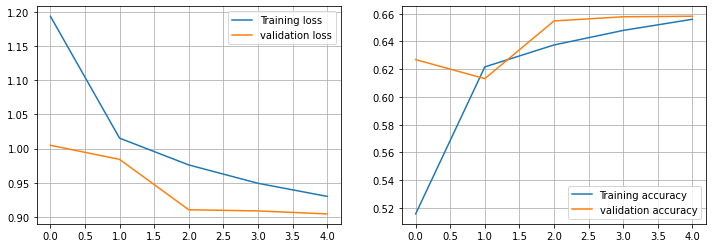

In [59]:
def plot_history(history):
    
    plt.figure(figsize=(12,4))
    plt.subplot(121)
    plt.plot(history.history['loss'], label='Training loss')
    plt.plot(history.history['val_loss'], label='validation loss')
    plt.grid()
    plt.legend()

    plt.subplot(122)
    plt.plot(history.history['accuracy'], label='Training accuracy')
    plt.plot(history.history['val_accuracy'], label='validation accuracy')
    plt.grid()
    plt.legend()

plot_history(history1)

In [44]:
def make_model_bidirectional(X, y, embedding_length = 16):
    model = Sequential()
    model.add(Embedding(MAX_WORDS, embedding_length, input_length=X.shape[1]))
    model.add(Bidirectional(LSTM(32, return_sequences=True, dropout=0.2, recurrent_dropout=0.2)))
    model.add(Conv1D(32, kernel_size = 3, padding = "valid"))
    model.add(GlobalMaxPool1D())
    #model.add(Dense(16, activation='sigmoid'))
    model.add(Dense(y.shape[1], activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

model2 = make_model_bidirectional(X_train, y_train)
model2.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 30, 16)            48000     
_________________________________________________________________
bidirectional (Bidirectional (None, 30, 64)            12544     
_________________________________________________________________
conv1d (Conv1D)              (None, 28, 32)            6176      
_________________________________________________________________
global_max_pooling1d (Global (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 165       
Total params: 66,885
Trainable params: 66,885
Non-trainable params: 0
_________________________________________________________________


In [45]:
history2 = model2.fit(X_train, y_train,
                    validation_data=(X_val, y_val), 
                    epochs=2,
                    batch_size=16,
                    verbose=1)

Epoch 1/2
7302/7302 [==============================] - 1823s 248ms/step - loss: 1.1395 - accuracy: 0.5339 - val_loss: 0.9123 - val_accuracy: 0.6501
Epoch 2/2
7302/7302 [==============================] - 1811s 248ms/step - loss: 0.8993 - accuracy: 0.6553 - val_loss: 0.8788 - val_accuracy: 0.6639


1217/1217 [==============================] - 21s 17ms/step - loss: 0.8907 - accuracy: 0.6589
Test accuracy: 65.89%


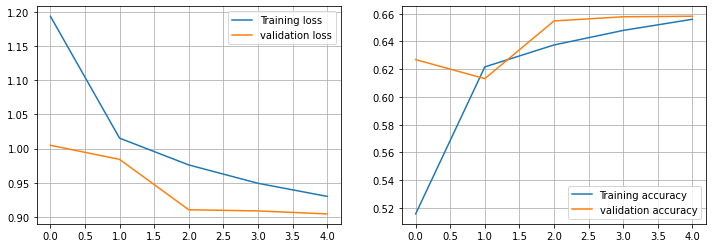

In [46]:
score = model2.evaluate(X_test, y_test)
print("Test accuracy: %.2f%%" % (score[1]*100))
plot_history(history1)

In [47]:
from sklearn.metrics import confusion_matrix

In [48]:
ypred = model2.predict(X_test)

In [49]:
np.argmax(y_test,axis=1)

array([0, 1, 2, ..., 2, 0, 0])

In [50]:
confusionmatrix=confusion_matrix(np.argmax(y_test,axis=1),np.argmax(ypred,axis=1))

In [51]:
confusionmatrix

array([[5450, 1051,  406,  306,  555],
       [ 711, 4716,  998,  820,  562],
       [ 319,  656, 5778,  761,  343],
       [ 532,  961, 1383, 3991,  840],
       [ 334,  193,  417, 1133, 5725]])

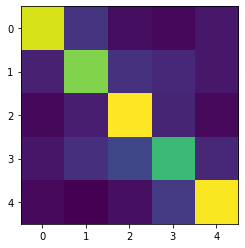

In [52]:
plt.imshow(confusionmatrix)

## Save the Model, tokenizer and configs

In [53]:
import pickle
import json

model2.save('model_biLSTM')


with open('tokenizer.pkl', 'wb') as fp:
    pickle.dump(tokenizer, fp)

config = {"MAX_WORDS": MAX_WORDS, 
          'MAX_SEQ_LEN': MAX_SEQ_LEN}

with open('config.json', 'w') as fp:
    json.dump(config, fp, indent = 4)

INFO:tensorflow:Assets written to: model_biLSTM/assets


## Load the saved Model, tokenizer and configs

In [54]:
# loading the saved model, vocab, filtered_words
from tensorflow.keras.models import load_model
model = load_model('./model_biLSTM')

with open('tokenizer.pkl', 'rb') as fp:
    tokenizer=pickle.load(fp) 
    
with open('config.json', 'r') as fp:
    config=json.load(fp)
    MAX_SEQ_LEN = config['MAX_SEQ_LEN']
    MAX_WORDS = config['MAX_WORDS']

print ("Model Loaded.")

Model Loaded.


## Predictions

In [55]:
def Prediction(txt_orig, model=model2, tokenizer=tokenizer, MAX_SEQ_LEN=MAX_SEQ_LEN):
    sent_dict={0:'very_bad', 1:'bad', 2:'neutral', 3:'good', 4:'very_good'}
    txt = process_twt(txt_orig)
    X_in = tokenizer.texts_to_sequences([txt])
    X_in = pad_sequences(X_in, maxlen=MAX_SEQ_LEN, padding='post', truncating='post')
    y_out = model.predict(X_in)
    sent = np.argmax(y_out,axis=1)[0]

    print (f"The following text\n\n {txt_orig} \n\n\
    has a sentiment \n {sent} ({sent_dict[sent]})\n\n on the following scale\n\n\
    {sent_dict}")

text1 = " $AAPL had a big increase. I am really happy for this."
Prediction(text1)

The following text

  $AAPL had a big increase. I am really happy for this. 

    has a sentiment 
 3 (good)

 on the following scale

    {0: 'very_bad', 1: 'bad', 2: 'neutral', 3: 'good', 4: 'very_good'}


In [56]:
text = " It was an okay ride for the $GOOG stock this week"
Prediction(text)

The following text

  It was an okay ride for the $GOOG stock this week 

    has a sentiment 
 2 (neutral)

 on the following scale

    {0: 'very_bad', 1: 'bad', 2: 'neutral', 3: 'good', 4: 'very_good'}


In [57]:
text = " It was an okay ride for the $GOOG stock this week. But still an increase in the share price."
Prediction(text)

The following text

  It was an okay ride for the $GOOG stock this week. But still an increase in the share price. 

    has a sentiment 
 3 (good)

 on the following scale

    {0: 'very_bad', 1: 'bad', 2: 'neutral', 3: 'good', 4: 'very_good'}


In [58]:
text = " Not a great week for $AAPL stock this week."
Prediction(text)

The following text

  Not a great week for $AAPL stock this week. 

    has a sentiment 
 2 (neutral)

 on the following scale

    {0: 'very_bad', 1: 'bad', 2: 'neutral', 3: 'good', 4: 'very_good'}
